# 

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import collections
import sys
import textwrap
import warnings
from functools import partial, reduce
from importlib import reload
from pathlib import Path
from pprint import pprint

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import pandas as pd
import torch

sys.path.append("../src")
import clip
import valuation
from opendataval.dataloader import DataFetcher
from opendataval.dataval import (
    DataOob,
    DataShapley,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)
from opendataval.model import ClassifierSkLearnWrapper, RegressionSkLearnWrapper
from PIL import Image
from scipy.stats import kendalltau, pearsonr
from sklearn import random_projection
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    DistanceMetric,
    accuracy_score,
    adjusted_mutual_info_score,
    f1_score,
    v_measure_score,
)
from sklearn.metrics.cluster import homogeneity_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.rcParams["font.family"] = "serif"
fig_dir = Path("figures")
from collections import defaultdict

warnings.filterwarnings("ignore", category=ConvergenceWarning)


[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

In [2]:
saved_embedding_path = Path("../embeddings")

clean_med = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224.pt"
    ),
    "breastmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224.pt"
    ),
    "chestmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224.pt"
    ),
    "dermamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224.pt"
    ),
    "pathmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224.pt"
    ),
    "retinamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224.pt"
    ),
    "tissuemnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224.pt"
    ),
    "organamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224.pt"
    ),
}


# Noisy version that is low pass filtered and cropped
noise_med = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224_noise.pt"
    ),
    "breastmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224_noise.pt"
    ),
    "chestmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224_noise.pt"
    ),
    "dermamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224_noise.pt"
    ),
    "pathmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224_noise.pt"
    ),
    "retinamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224_noise.pt"
    ),
    "tissuemnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224_noise.pt"
    ),
    "organamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224_noise.pt"
    ),
}

In [3]:
# Mixture of all medmnist datasets
med = torch.cat(
    [
        v["embeddings"][: int(10000 / 5)]
        for k, v in clean_med.items()
    ]
)
med = med[torch.randperm(med.size(0))]

In [4]:
# Other irrelevant datasets to compare
cifar = torch.load(saved_embedding_path / "clip_embedding_cifar_seller.pt")
fashion = torch.load(saved_embedding_path / "clip_embedding_fashion_seller.pt")
mnist = torch.load(saved_embedding_path / "clip_embedding_mnist_seller.pt")

## Qualitative experiments

### Visually compare different combinations of diversity and relevance

In [5]:
n_buy = 100
n_sell = 10000

# buyer = "bloodmnist"
# buyer = 'chestmnist'
# buyer = 'pathmnist'
buyer = 'tissuemnist'
# buyer = 'dermamnist'
# buyer = 'organamnist'
# buyer = 'retinamnist'

sellers = list(set(clean_med.keys()) - set([buyer]))
n_buy = 100
n_sell = 3000
buyer_data = clean_med[buyer]["embeddings"][-n_buy:]
sellers_data = {s: clean_med[s]['embeddings'][:n_sell] for s in sellers}
sellers_data['IID'] = clean_med[buyer]["embeddings"][:n_sell]
sellers_data['mnist'] = mnist["images"][:n_sell]
# sellers_data['fashion'] = fashion["images"][:n_sell]
sellers_data['cifar'] = cifar["images"][:n_sell]

seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        # cifar['images'][-100:], v,
        n_components=10,
        # normalize=True,
        use_neg_components=True,
        # use_dp=True,
        # dp_epsilon=0.1,
        # dp_delta=1e6,
    )
    for k, v in tqdm(sellers_data.items())
}

  0%|          | 0/10 [00:00<?, ?it/s]

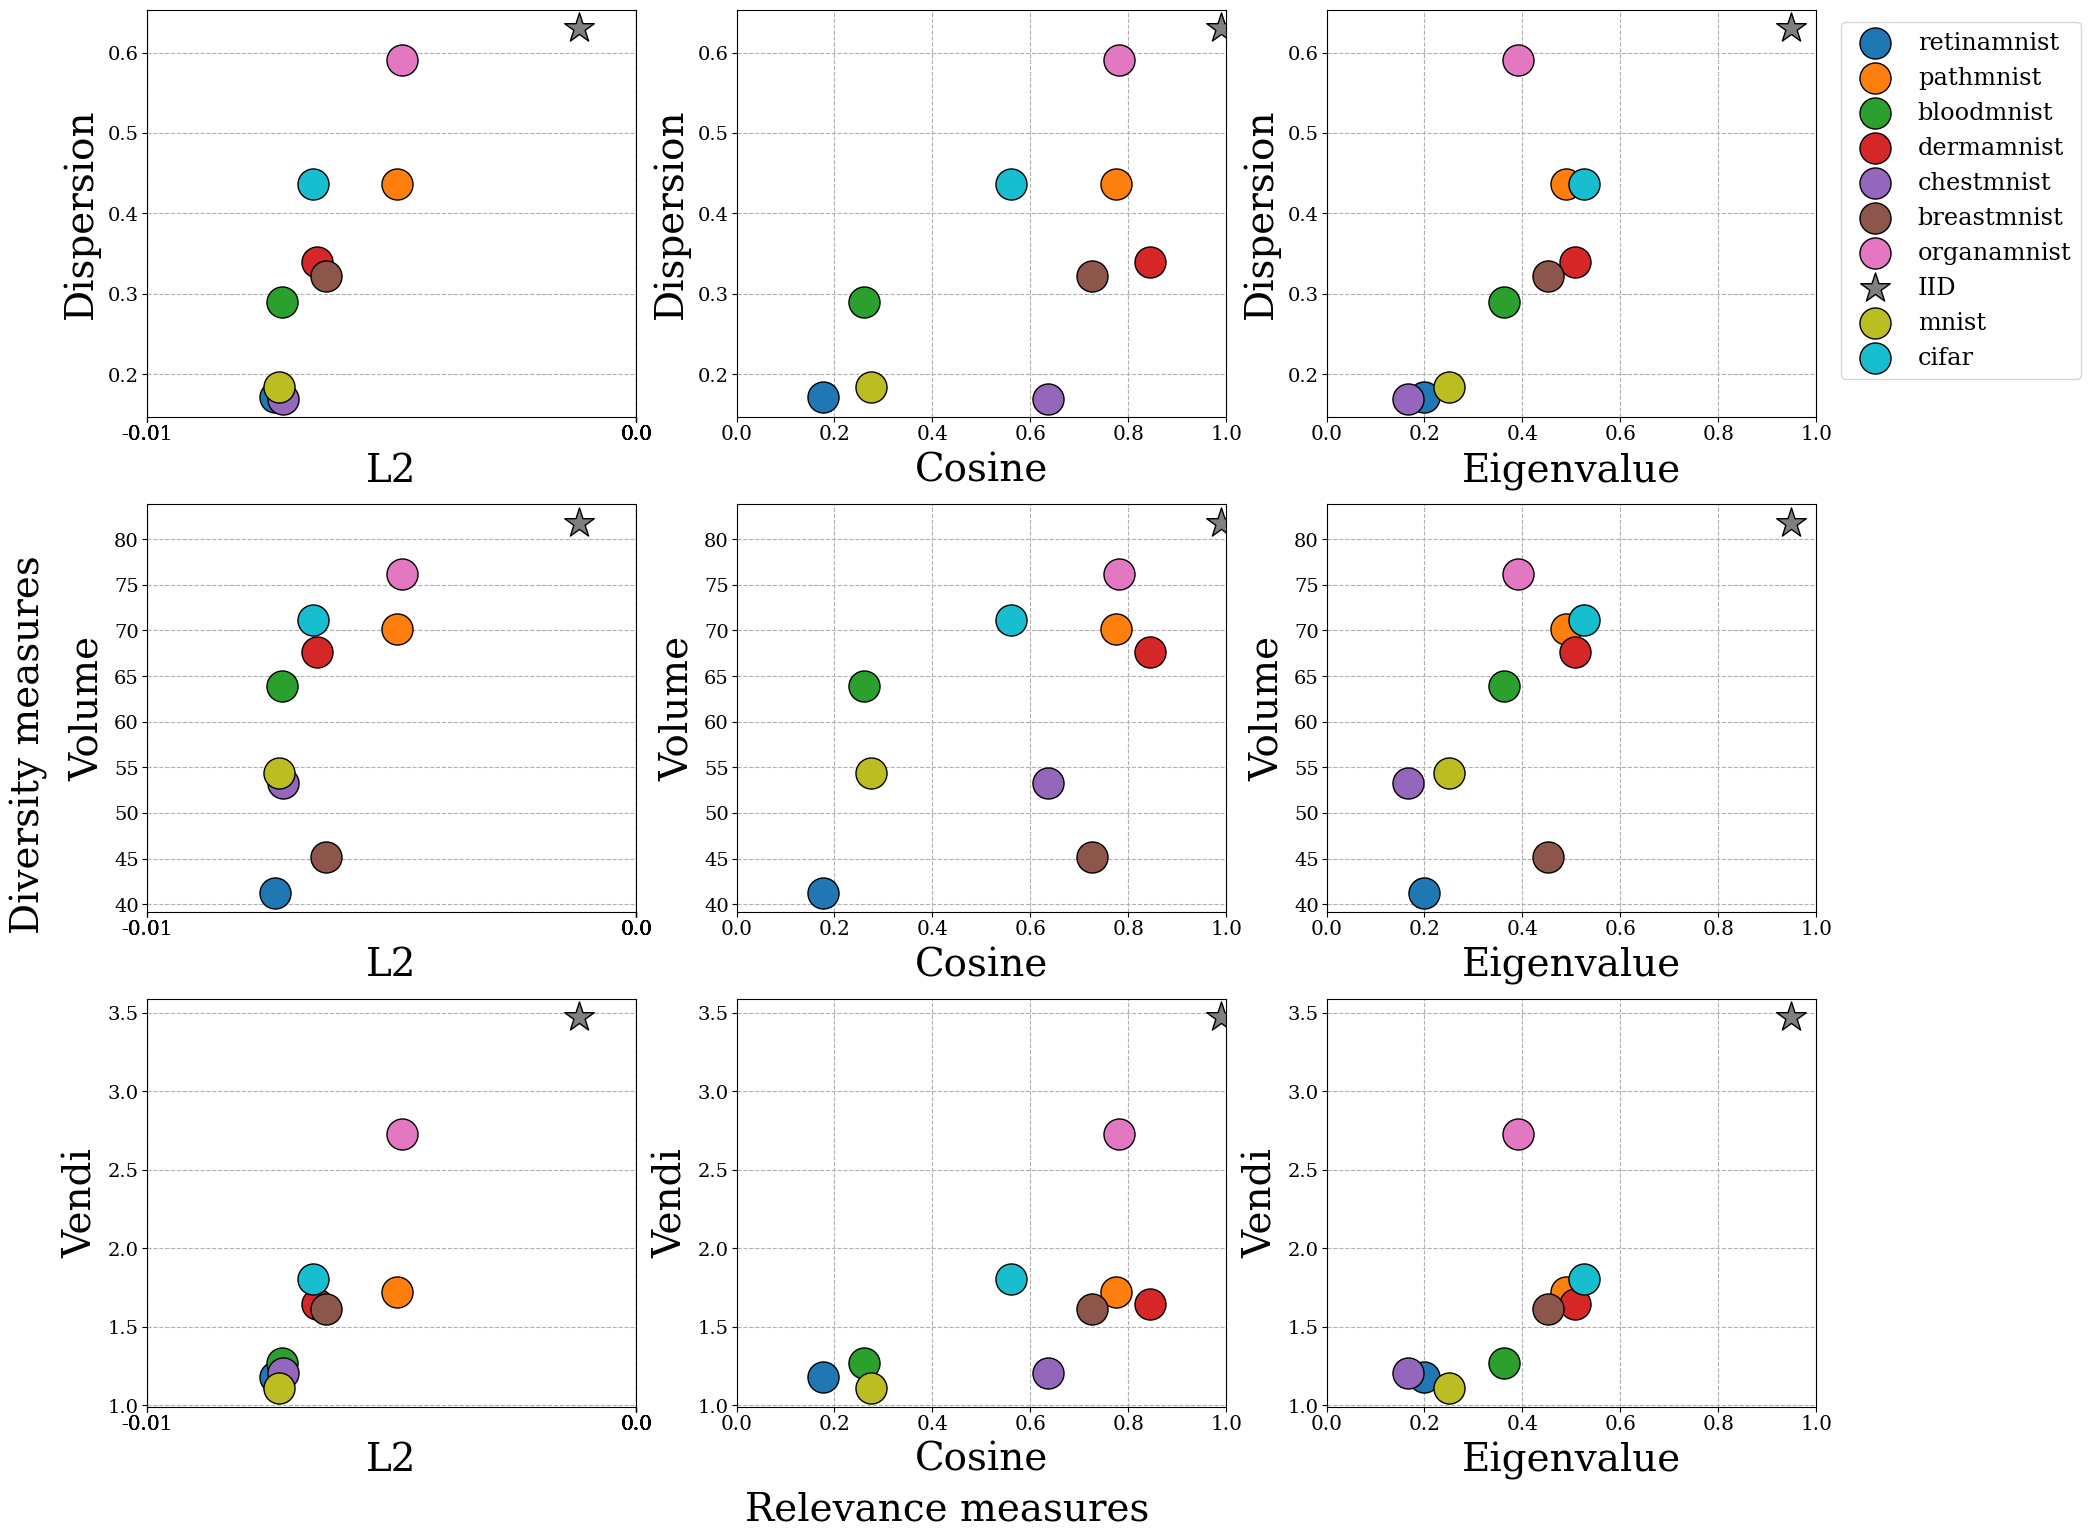

In [6]:
fontsize = 28
size = 500

fig, axs = plt.subplots(3, 3, figsize=(18, 15))

for i, (k, v) in enumerate(seller_values.items()):
   
    marker = '*'  if k == 'IID' else 'o'

    scatter_kwargs = dict(edgecolor="k", s=size, zorder=2, marker=marker)
    rel = v["relevance"]
    l2 = v["l2"]
    cos = v["cosine"]
    ven = v["vendi"]
    vol = v["volume"]
    dis = v["dispersion"]  

    axs[0, 0].scatter(l2, dis, label=k, **scatter_kwargs)
    axs[1, 0].scatter(l2, vol, **scatter_kwargs)
    axs[2, 0].scatter(l2, ven, **scatter_kwargs)
    axs[0, 1].scatter(cos, dis, **scatter_kwargs)
    axs[1, 1].scatter(cos, vol, **scatter_kwargs)
    axs[2, 1].scatter(cos, ven, **scatter_kwargs)
    axs[0, 2].scatter(rel, dis, **scatter_kwargs)
    axs[1, 2].scatter(rel, vol, **scatter_kwargs)
    axs[2, 2].scatter(rel, ven, **scatter_kwargs)

axs[0, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[1, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[2, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[0, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[1, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[2, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[0, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[1, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[2, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[0, 0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 1].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 2].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1, 0].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 2].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2, 0].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 1].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)


fig.text(0.5, -0.01, "Relevance measures", ha="center", va="center", fontsize=fontsize)
fig.text(
    -0.01,
    0.5,
    "Diversity measures",
    ha="center",
    va="center",
    fontsize=fontsize,
    rotation=90,
)

for ax in axs.flat:
    # ax.set_xlim(0, 1)
    ax.tick_params(axis="both", labelsize=14, pad=2)
    
    if ax.get_xlabel() != 'L2':
        ax.set_xlim(right=1)
    ax.set_xticks([round(x, 2) for x in ax.get_xticks()])
    ax.set_xticklabels(ax.get_xticks(), fontsize="x-large")
    ax.grid(ls="--", zorder=0)
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)
    # ax

# fig.legend(bbox_to_anchor=(0.15, -0.03), loc='upper left', fontsize='xx-large', ncols=4)
fig.legend(bbox_to_anchor=(0.99, 0.99), loc="upper left", fontsize="xx-large", ncols=1)
fig.tight_layout(h_pad=1, w_pad=0)
# plt.savefig(fig_dir / f"{buyer}.eps", bbox_inches='tight')

### Interpolate between domains (in-domain versus out of domain)

In [7]:
def interpolate(a, b, num_samples=10000, num_parts=10):
    """ 
    Interpolate number samples between two datasets
    Return dictionary with `num_parts` datasets with 
    varying proportions of dataset `a` and `b`
    starting with 1 part `a` and 9 parts `b`
    and ending with 10 parts `b`
    """
    n = int(min(len(a), len(b), num_samples) / num_parts)
    ret = {
        j: torch.cat([a[: n * (num_parts - j)], b[: n * j]])
        for j in range(1, num_parts + 1)
    }
    return ret


In [8]:
sellers = {}
num_parts = 10
parts = 100 // num_parts

for k, v in interpolate(
    clean_med[buyer]["embeddings"][:num_seller],
    noise_med[buyer]["embeddings"][:num_seller],
).items():
    sellers[f"{parts * k}% Noisy {buyer.capitalize()}"] = v

for k, v in interpolate(
    clean_med[buyer]["embeddings"][:num_seller], 
    med[:num_seller], num_parts=num_parts
).items():
    sellers[f"{parts * k}% MedMNIST"] = v

for k, v in interpolate(
    clean_med[buyer]["embeddings"][:num_seller],
    mnist["images"][:num_seller],
    num_parts=num_parts,
).items():
    sellers[f"{parts * k}% MNIST"] = v

for k, v in interpolate(
    clean_med[buyer]["embeddings"][:num_seller],
    cifar["images"][:num_seller],
    num_parts=num_parts,
).items():
    sellers[f"{parts * k}% CIFAR"] = v

interp_seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        n_components=10,
        # normalize=True,
        use_neg_components=True,
    )
    for k, v in tqdm(sellers.items())
}

NameError: name 'num_seller' is not defined

In [ ]:
num = num_parts
# num += 1
# cmap1 = plt.cm.inferno
# cmap1 = cmap1(np.linspace(0.1, 1, 10))
# cmap2 = plt.cm.viridis
# cmap2 = cmap2(np.linspace(0.1, 1, 10))
# cmap3 = plt.cm.cividis
# cmap3 = cmap3(np.linspace(0.1, 1, 10))

rang = np.linspace(1, 0, num)
greens = plt.cm.YlGn(rang)
viridis = plt.cm.viridis(rang)
cividis = plt.cm.cividis(rang)
plasma = plt.cm.inferno(rang)
magma = plt.cm.inferno(rang)

cmap = plt.cm.viridis
colors = cmap(np.linspace(0.2, 1, len(seller_values)))

fontsize = 28
size = 500

fig, axs = plt.subplots(3, 3, figsize=(18, 15))

for i, (k, v) in enumerate(interp_seller_values.items()):
    print(k)

    match k:
        case str(name) if name == buyer.capitalize():
            marker = "*"
            c = "darkgray"
            s = size + 100
        case str(name) if "noisy" in name.lower():
            # j = (int(name.split()[0][:-1]) // num) -1
            marker = "o"
            # c = greens[~j]
            c = viridis[i % num]
            s = size
        case str(name) if name.split()[1] == "MedMNIST":
            # j = (int(name.split()[0][:-1]) // num) -1
            c = cividis[i % num]
            marker = "d"
            s = size
        case str(name) if name.split()[1] == "MNIST":
            # j = (int(name.split()[0][:-1]) // num) -1
            c = plasma[i % num]
            marker = "X"
            s = size
        case str(name) if "cifar" in name.lower():
            # j = (int(name.split()[0][:-1]) // num) -1
            c = magma[i % num]
            marker = "P"
            s = size
        case _:
            print(k)
            raise

    scatter_kwargs = dict(color=c, edgecolor="k", s=s, zorder=2, marker=marker)
    # cos = (1 + v['cosine']) - (1 + v['neg_cosine'])
    cos = v["cosine"]
    ven = v["vendi"]
    vol = v["volume"]
    dis = v["dispersion"]  # - v['neg_dispersion']

    axs[0, 0].scatter(v["l2"], dis, label=k, **scatter_kwargs)
    axs[1, 0].scatter(v["l2"], vol, **scatter_kwargs)
    axs[2, 0].scatter(v["l2"], ven, **scatter_kwargs)
    axs[0, 1].scatter(cos, dis, **scatter_kwargs)
    axs[1, 1].scatter(cos, vol, **scatter_kwargs)
    axs[2, 1].scatter(cos, ven, **scatter_kwargs)
    axs[0, 2].scatter(v["relevance"], dis, **scatter_kwargs)
    axs[1, 2].scatter(v["relevance"], vol, **scatter_kwargs)
    axs[2, 2].scatter(v["relevance"], ven, **scatter_kwargs)

axs[0, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[1, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[2, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[0, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[1, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[2, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[0, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[1, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[2, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[0, 0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 1].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 2].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1, 0].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 2].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2, 0].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 1].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)


axs[0, 0].set_xticklabels(axs[0, 0].get_xticks(), fontsize="x-large")
axs[0, 1].set_xticklabels(axs[0, 1].get_xticks(), fontsize="x-large")
axs[0, 2].set_xticklabels(axs[0, 2].get_xticks(), fontsize="x-large")

axs[1, 0].set_xticklabels(axs[1, 0].get_xticks(), fontsize="x-large")
axs[1, 1].set_xticklabels(axs[1, 1].get_xticks(), fontsize="x-large")
axs[1, 2].set_xticklabels(axs[1, 2].get_xticks(), fontsize="x-large")

axs[2, 0].set_xticklabels(axs[2, 0].get_xticks(), fontsize="x-large")
axs[2, 1].set_xticklabels(axs[2, 1].get_xticks(), fontsize="x-large")
axs[2, 2].set_xticklabels(axs[2, 2].get_xticks(), fontsize="x-large")


fig.text(0.5, -0.01, "Relevance measures", ha="center", va="center", fontsize=fontsize)
fig.text(
    -0.01,
    0.5,
    "Diversity measures",
    ha="center",
    va="center",
    fontsize=fontsize,
    rotation=90,
)

for ax in axs.flat:
    ax.tick_params(axis="both", labelsize=14, pad=2)
    ax.grid(ls="--", zorder=0)
    ax.set_xticks([round(x, 2) for x in ax.get_xticks()])
    ax.set_xticklabels(ax.get_xticks(), fontsize="x-large")
    
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)
    # ax

# fig.legend(bbox_to_anchor=(0.15, -0.03), loc='upper left', fontsize='xx-large', ncols=4)
fig.legend(bbox_to_anchor=(0.99, 0.99), loc="upper left", fontsize="xx-large", ncols=1)
fig.tight_layout(h_pad=1, w_pad=0)
# plt.savefig(fig_dir / f"{buyer}.eps", bbox_inches='tight')

### False projections

In [9]:
sellers = list(set(clean_med.keys()) - set([buyer]))
n_buy = 100
n_sell = 3000
buyer_data = clean_med[buyer]["embeddings"][-n_buy:]
u1 = valuation.get_value(buyer_data, clean_med[buyer]["embeddings"][:n_sell])
u2 = valuation.get_value(buyer_data, clean_med[sellers[0]]["embeddings"][:n_sell])
u3 = valuation.get_value(buyer_data, clean_med[sellers[1]]["embeddings"][:n_sell])
u4 = valuation.get_value(buyer_data, clean_med[sellers[2]]["embeddings"][:n_sell])
u5 = valuation.get_value(buyer_data, clean_med[sellers[3]]["embeddings"][:n_sell])
u6 = valuation.get_value(buyer_data, cifar["images"][:n_sell])

false_data = fashion["images"][-n_buy:]
v1 = valuation.get_value(false_data, clean_med[buyer]["embeddings"][:n_sell])
v2 = valuation.get_value(false_data, clean_med[sellers[0]]["embeddings"][:n_sell])
v3 = valuation.get_value(false_data, clean_med[sellers[1]]["embeddings"][:n_sell])
v4 = valuation.get_value(false_data, clean_med[sellers[2]]["embeddings"][:n_sell])
v5 = valuation.get_value(false_data, clean_med[sellers[3]]["embeddings"][:n_sell])
v6 = valuation.get_value(false_data, cifar["images"][:n_sell])

random_data = np.exp(np.random.exponential(size=(100, 512), scale=0.2))
w1 = valuation.get_value(random_data, clean_med[buyer]["embeddings"][:n_sell])
w2 = valuation.get_value(random_data, clean_med[sellers[0]]["embeddings"][:n_sell])
w3 = valuation.get_value(random_data, clean_med[sellers[1]]["embeddings"][:n_sell])
w4 = valuation.get_value(random_data, clean_med[sellers[2]]["embeddings"][:n_sell])
w5 = valuation.get_value(random_data, clean_med[sellers[3]]["embeddings"][:n_sell])
w6 = valuation.get_value(random_data, cifar["images"][:n_sell])

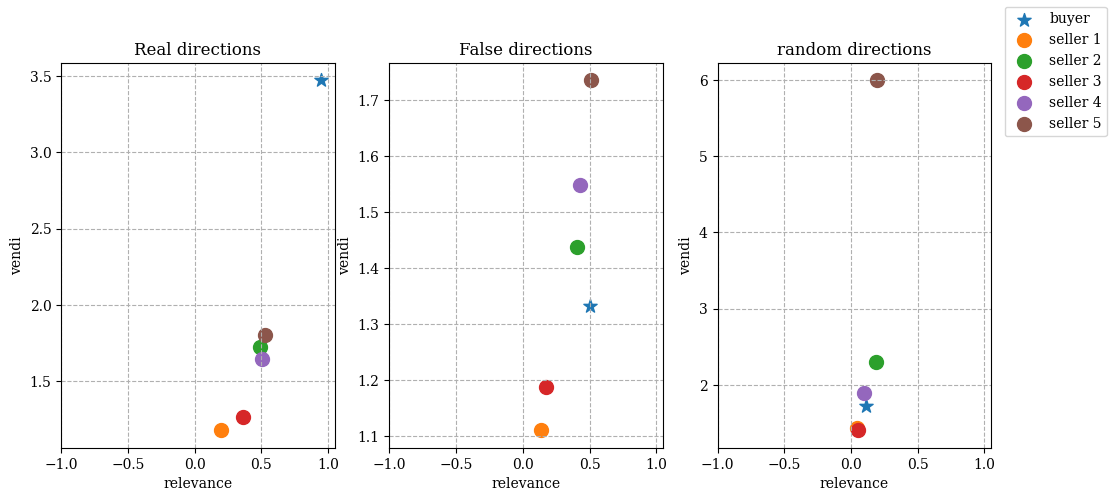

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
div = 'vendi'
rel = 'relevance'

markersize = 100
ax[0].set_title("Real directions")
ax[0].scatter(u1[rel], u1[div], marker="*", label="buyer", s=markersize)
ax[0].scatter(u2[rel], u2[div], label="seller 1", s=markersize)
ax[0].scatter(u3[rel], u3[div], label="seller 2", s=markersize)
ax[0].scatter(u4[rel], u4[div], label="seller 3", s=markersize)
ax[0].scatter(u5[rel], u5[div], label="seller 4", s=markersize)
ax[0].scatter(u6[rel], u6[div], label="seller 5", s=markersize)
ax[1].set_title("False directions")
ax[1].scatter(v1[rel], v1[div], marker="*", s=markersize)
ax[1].scatter(v2[rel], v2[div], s=markersize)
ax[1].scatter(v3[rel], v3[div], s=markersize)
ax[1].scatter(v4[rel], v4[div], s=markersize)
ax[1].scatter(v5[rel], v5[div], s=markersize)
ax[1].scatter(v6[rel], v6[div], s=markersize)
ax[2].set_title("random directions")
ax[2].scatter(w1[rel], w1[div], marker="*", s=markersize)
ax[2].scatter(w2[rel], w2[div], s=markersize)
ax[2].scatter(w3[rel], w3[div], s=markersize)
ax[2].scatter(w4[rel], w4[div], s=markersize)
ax[2].scatter(w5[rel], w5[div], s=markersize)
ax[2].scatter(w6[rel], w6[div], s=markersize)
for _ax in ax:
    _ax.set_xlabel(rel)
    _ax.set_ylabel(div)
    _ax.set_xlim(-1, 1.05)
    # _ax.set_ylim(25, 100)
    _ax.grid(ls="--")
fig.legend()

## Quantitative experiments

In [242]:
# Subset of classes that the buyer cares about
# Both buyer query and test set will come from this subset of labels
sev_classes = {
    "pathmnist": [8, 7, 6],
    "dermamnist": [4, 1, 0],
    "bloodmnist": [6, 5, 4],
    "chestmnist": [6, 7],
    "breastmnist": [0],
    "tissuemnist": [2, 5, 6],
    "retinamnist": [1, 2, 3],
    "organamnist": [7, 8, 3, 6],
}

In [243]:
total_classes = {k: len(v["label"]) for k, v in medmnist.INFO.items()}
total_classes

{'pathmnist': 9,
 'chestmnist': 14,
 'dermamnist': 7,
 'octmnist': 4,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'breastmnist': 2,
 'bloodmnist': 8,
 'tissuemnist': 8,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'organmnist3d': 11,
 'nodulemnist3d': 2,
 'adrenalmnist3d': 2,
 'fracturemnist3d': 3,
 'vesselmnist3d': 2,
 'synapsemnist3d': 2}

In [244]:
for k, v in medmnist.INFO.items():
    if k in sev_classes:
        print(k.upper(), [v["label"][str(a)] for a in sev_classes[k]])

PATHMNIST ['colorectal adenocarcinoma epithelium', 'cancer-associated stroma', 'normal colon mucosa']
CHESTMNIST ['pneumonia', 'pneumothorax']
DERMAMNIST ['melanoma', 'basal cell carcinoma', 'actinic keratoses and intraepithelial carcinoma']
RETINAMNIST ['1', '2', '3']
BREASTMNIST ['malignant']
BLOODMNIST ['neutrophil', 'monocyte', 'lymphocyte']
TISSUEMNIST ['Glomerular endothelial cells', 'Podocytes', 'Proximal Tubule Segments']
ORGANAMNIST ['lung-left', 'lung-right', 'heart', 'liver']


In [245]:
def sample_dirichlet_by_class(
    x, y, num_sellers=10, num_samples=1000, add_to_alpha=1, min_samples=0
):
    """
    Sample seller data according to dirichlet class distribution
    taking into consideration class frequency
    """
    y = y.squeeze().numpy()
    class_counts = np.bincount(y)
    class_prop = class_counts / class_counts.sum()
    class_weights = np.random.dirichlet(add_to_alpha + class_prop, size=num_sellers)
    sample_weights = {i: v[y] for i, v in enumerate(class_weights)}
    sample_weights = {k: v / v.sum() for k, v in sample_weights.items()}

    rang = np.arange(len(x))
    seller_indexes = {
        k: np.random.choice(rang, size=num_samples, replace=False, p=v)
        for k, v in sample_weights.items()
    }
    if min_samples > 0:
        new_index = []
        for c in np.unique(y):
            class_index = np.where(y == c)[0][:min_samples]
            new_index.extend(class_index)

        for k in seller_indexes:
            seller_indexes[k][: len(new_index)] = new_index

    return seller_indexes

In [246]:
def compute_utility(
    x_train,
    y_train,
    x_test,
    y_test,
    model=partial(LogisticRegression, max_iter=200),
    # utility=accuracy_score,
    utility=partial(f1_score, average="macro"),
    # utility=partial(f1_score, average=None),
    n_clusters=None,
):
    if n_clusters is not None:
        M = model(n_clusters=n_clusters)
    else:
        M = model()
    M.fit(x_train, y_train)
    y_pred = M.predict(x_test)
    return utility(y_test, y_pred)


binary_utility = partial(
    compute_utility,
    model=partial(LogisticRegression, max_iter=200),
    utility=partial(f1_score, average="macro"),
)
multi_utility = partial(
    compute_utility,
    model=partial(RandomForestClassifier, n_estimators=10, max_depth=5),
    utility=partial(f1_score, average="macro"),
)
cluster_utility = partial(
    compute_utility,
    model=partial(KMeans, n_clusters=10, n_init="auto"),
    utility=lambda true, pred: homogeneity_score(true.squeeze(), pred.squeeze()),
)

In [247]:
datasets = [
    "bloodmnist",
    "dermamnist",
    "retinamnist",
    "breastmnist",
    "pathmnist",
    "tissuemnist",
    "organamnist",
]

results = defaultdict(dict)

for d in datasets:
    x = clean_med[d]["embeddings"].float()
    y = clean_med[d]["labels"]

    if d == "breastmnist":
        num_buyer = 50
        num_samples = 250
        print("breast")
    elif d == "dermamnist":
        num_buyer = 100
        num_samples = 1500
        print("derma")
    elif d == "pathmnist":
        num_buyer = 100
        num_samples = 1500
        print("path")
    elif d == "retinamnist":
        num_buyer = 100
        num_samples = 500
        print("retina")
    elif d == "Tissuemnist":
        num_buyer = 1500
        num_samples = 25000
        print("tissue")
    else:
        num_buyer = 500
        num_samples = 5000
        print("other")

    x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.3)
    print(x_dev.shape, x_test.shape)

    cs = torch.tensor(sev_classes[d])

    if d == "chestmnist":
        buyer_index = reduce(
            torch.logical_or, torch.chunk(y_test[:, cs], len(cs), dim=1)
        ).flatten()
    else:
        buyer_index = torch.isin(y_test.squeeze(), cs)

    x_buyer = x_test[buyer_index][:num_buyer]
    y_buyer = y_test[buyer_index][:num_buyer]

    class_bc = []
    vs = []
    bin_us = []
    multi_us = []
    cluster_us = []
    num_corr_class = []

    for i, (k, v) in tqdm(
        enumerate(
            sample_dirichlet_by_class(
                x_dev,
                y_dev,
                num_sellers=500,
                num_samples=num_samples,
                add_to_alpha=0.2,
                min_samples=1,
            ).items()
        )
    ):
        x_k = x_dev[v]
        y_k = y_dev.squeeze()[v]

        bc = np.bincount(y_k, minlength=total_classes[d])
        class_bc.append(bc)

        total = 0
        for c in cs:
            total += bc[c]
        num_corr_class.append(total)

        v = valuation.get_value(x_buyer, x_k)
        vs.append(v)

        bin_u = binary_utility(
            x_k,
            torch.isin(y_k, cs),
            x_test,
            buyer_index,
        )

        multi_u = multi_utility(
            x_k,
            y_k,
            x_test,
            y_test,
        )

        cluster_u = cluster_utility(
            x_k,
            y_k,
            x_test,
            y_test,
            n_clusters=len(sev_classes[d]),
        )

        bin_us.append(bin_u)
        multi_us.append(multi_u)
        cluster_us.append(cluster_u)

        if i % 20 == 0:
            print(
                k,
                bc,
                f"{bin_u:.2f}",
                f"{multi_u:.2f}",
                f"{cluster_u:.2f}",
                {k: round(v_, 2) for k, v_ in v.items()},
            )

    results[d]["class_bc"] = class_bc
    results[d]["vs"] = vs
    results[d]["bin_us"] = bin_us
    results[d]["multi_us"] = multi_us
    results[d]["cluster_us"] = cluster_us
    results[d]["num_corr_class"] = num_corr_class

other
torch.Size([8371, 512]) torch.Size([3588, 512])


0it [00:00, ?it/s]

0 [   7 1504    3  402    1  668 1261 1154] 0.87 0.40 0.21 {'relevance': 0.77, 'l2': -0.0, 'cosine': 0.93, 'diversity': 0.16, 'volume': 83.04, 'vendi': 2.75, 'dispersion': 0.52}
20 [ 232 1505    9  401  617  571 1040  625] 0.89 0.49 0.22 {'relevance': 0.84, 'l2': -0.0, 'cosine': 0.97, 'diversity': 0.12, 'volume': 83.33, 'vendi': 2.74, 'dispersion': 0.52}
40 [ 557 1503   30    3  592  673 1624   18] 0.73 0.36 0.19 {'relevance': 0.89, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.08, 'volume': 83.21, 'vendi': 2.65, 'dispersion': 0.51}
60 [ 163  191  750  424  618  365 1336 1153] 0.90 0.43 0.23 {'relevance': 0.79, 'l2': -0.0, 'cosine': 0.96, 'diversity': 0.15, 'volume': 83.23, 'vendi': 2.82, 'dispersion': 0.51}
80 [   1 1505  620 1441   75    9  560  789] 0.80 0.45 0.25 {'relevance': 0.78, 'l2': -0.0, 'cosine': 0.93, 'diversity': 0.12, 'volume': 82.86, 'vendi': 2.62, 'dispersion': 0.51}
100 [ 246  883  736 1368    1   83 1304  379] 0.83 0.47 0.27 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.9

0it [00:00, ?it/s]

0 [  19   10   34    2   80 1347    8] 0.65 0.12 0.05 {'relevance': 0.81, 'l2': -0.0, 'cosine': 0.78, 'diversity': 0.14, 'volume': 75.96, 'vendi': 2.76, 'dispersion': 0.67}
20 [   6  115    1   28    6 1314   30] 0.68 0.15 0.06 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.76, 'diversity': 0.16, 'volume': 76.32, 'vendi': 2.86, 'dispersion': 0.68}
40 [   9    4    1   12  147 1326    1] 0.70 0.12 0.05 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.79, 'diversity': 0.17, 'volume': 76.1, 'vendi': 2.77, 'dispersion': 0.68}
60 [   7   15   18    1    6 1452    1] 0.53 0.12 0.03 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.71, 'diversity': 0.13, 'volume': 75.79, 'vendi': 2.71, 'dispersion': 0.67}
80 [ 30 254 536  63   1 614   2] 0.66 0.22 0.05 {'relevance': 0.88, 'l2': -0.0, 'cosine': 0.98, 'diversity': 0.1, 'volume': 77.48, 'vendi': 3.16, 'dispersion': 0.72}
100 [   1    1    7    1    4 1485    1] 0.45 0.12 0.05 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.68, 'diversity': 0.15, 'volume': 75.8, 'ven

0it [00:00, ?it/s]

0 [212  53 141  93   1] 0.76 0.35 0.10 {'relevance': 0.87, 'l2': -0.0, 'cosine': 0.93, 'diversity': 0.1, 'volume': 53.33, 'vendi': 1.53, 'dispersion': 0.42}
20 [331   1  73  57  38] 0.64 0.28 0.10 {'relevance': 0.88, 'l2': -0.0, 'cosine': 0.92, 'diversity': 0.05, 'volume': 53.39, 'vendi': 1.55, 'dispersion': 0.42}
40 [297  14 147  39   3] 0.72 0.23 0.05 {'relevance': 0.86, 'l2': -0.0, 'cosine': 0.92, 'diversity': 0.09, 'volume': 53.23, 'vendi': 1.53, 'dispersion': 0.42}
60 [195   2 132 130  41] 0.75 0.35 0.08 {'relevance': 0.91, 'l2': -0.0, 'cosine': 0.92, 'diversity': 0.08, 'volume': 54.18, 'vendi': 1.6, 'dispersion': 0.43}
80 [332  91  41  35   1] 0.70 0.19 0.09 {'relevance': 0.83, 'l2': -0.0, 'cosine': 0.92, 'diversity': 0.11, 'volume': 52.55, 'vendi': 1.48, 'dispersion': 0.4}
100 [266   2  93 122  17] 0.72 0.29 0.11 {'relevance': 0.89, 'l2': -0.0, 'cosine': 0.91, 'diversity': 0.08, 'volume': 53.48, 'vendi': 1.57, 'dispersion': 0.42}
120 [307  28   3 122  40] 0.67 0.25 0.08 {'releva

0it [00:00, ?it/s]

0 [ 99 151] 0.80 0.73 0.00 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.94, 'diversity': 0.12, 'volume': 52.39, 'vendi': 2.35, 'dispersion': 0.58}
20 [ 54 196] 0.70 0.62 0.00 {'relevance': 0.83, 'l2': -0.0, 'cosine': 0.92, 'diversity': 0.1, 'volume': 52.45, 'vendi': 2.39, 'dispersion': 0.59}
40 [ 28 222] 0.66 0.46 0.00 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.94, 'diversity': 0.15, 'volume': 52.19, 'vendi': 2.39, 'dispersion': 0.59}
60 [ 92 158] 0.80 0.69 0.00 {'relevance': 0.81, 'l2': -0.0, 'cosine': 0.95, 'diversity': 0.11, 'volume': 52.39, 'vendi': 2.34, 'dispersion': 0.58}
80 [  2 248] 0.42 0.42 0.00 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.94, 'diversity': 0.17, 'volume': 51.82, 'vendi': 2.4, 'dispersion': 0.58}
100 [  5 245] 0.42 0.42 0.00 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.93, 'diversity': 0.14, 'volume': 51.76, 'vendi': 2.38, 'dispersion': 0.58}
120 [101 149] 0.79 0.75 0.00 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.96, 'diversity': 0.13, 'volume': 52.29, 'vendi':

0it [00:00, ?it/s]

0 [  1   6   1   5   1 944 466  70   6] 0.74 0.15 0.18 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.93, 'diversity': 0.15, 'volume': 73.45, 'vendi': 2.41, 'dispersion': 0.61}
20 [677 459  42 238  15   1  46  20   2] 0.85 0.43 0.25 {'relevance': 0.29, 'l2': -0.01, 'cosine': 0.35, 'diversity': 0.64, 'volume': 74.03, 'vendi': 2.7, 'dispersion': 0.76}
40 [733  76   1  30  11 287 330  12  20] 0.84 0.39 0.25 {'relevance': 0.48, 'l2': -0.0, 'cosine': 0.68, 'diversity': 0.46, 'volume': 75.02, 'vendi': 2.62, 'dispersion': 0.7}
60 [ 259    1   58    3   40   16    8    1 1114] 0.79 0.25 0.25 {'relevance': 0.55, 'l2': -0.0, 'cosine': 0.78, 'diversity': 0.37, 'volume': 74.49, 'vendi': 2.46, 'dispersion': 0.65}
80 [  5   8 267 467 290 357   1   7  98] 0.77 0.36 0.23 {'relevance': 0.64, 'l2': -0.0, 'cosine': 0.86, 'diversity': 0.28, 'volume': 73.43, 'vendi': 2.45, 'dispersion': 0.64}
100 [390 289 147  16 599   1  31  15  12] 0.77 0.34 0.25 {'relevance': 0.36, 'l2': -0.01, 'cosine': 0.47, 'diversity': 

0it [00:00, ?it/s]

0 [ 256   13    1  102    9  439 3821  359] 0.46 0.09 0.04 {'relevance': 0.94, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.04, 'volume': 88.16, 'vendi': 3.71, 'dispersion': 0.64}
20 [2865   38   84   69    7    1 1636  300] 0.68 0.14 0.04 {'relevance': 0.83, 'l2': -0.0, 'cosine': 0.97, 'diversity': 0.12, 'volume': 87.5, 'vendi': 3.31, 'dispersion': 0.63}
40 [ 571  153 2591  196   14  836  634    5] 0.57 0.15 0.04 {'relevance': 0.78, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.16, 'volume': 87.1, 'vendi': 3.05, 'dispersion': 0.63}
60 [4572   25   36  273    2   76    1   15] 0.46 0.10 0.04 {'relevance': 0.72, 'l2': -0.0, 'cosine': 0.97, 'diversity': 0.18, 'volume': 86.02, 'vendi': 2.8, 'dispersion': 0.61}
80 [3919    1  218  394   32   34  226  176] 0.55 0.12 0.04 {'relevance': 0.73, 'l2': -0.0, 'cosine': 0.97, 'diversity': 0.18, 'volume': 86.53, 'vendi': 2.95, 'dispersion': 0.62}
100 [2599  611   13   89  668    3  607  410] 0.62 0.17 0.04 {'relevance': 0.78, 'l2': -0.0, 'cosine': 0.97, 

0it [00:00, ?it/s]

0 [  90  156  234    5   94    7 2679  449 1100  143   43] 0.98 0.38 0.38 {'relevance': 0.52, 'l2': -0.01, 'cosine': 0.8, 'diversity': 0.39, 'volume': 90.9, 'vendi': 2.37, 'dispersion': 0.77}
20 [ 472    1   26    3  658   45   19  154 1847 1543  232] 0.97 0.25 0.31 {'relevance': 0.5, 'l2': -0.01, 'cosine': 0.78, 'diversity': 0.36, 'volume': 88.96, 'vendi': 2.34, 'dispersion': 0.78}
40 [ 561  704    1  203   27  738 2367  120  217    1   61] 0.99 0.42 0.38 {'relevance': 0.36, 'l2': -0.01, 'cosine': 0.54, 'diversity': 0.55, 'volume': 90.08, 'vendi': 2.57, 'dispersion': 0.79}
60 [ 287   36   21  978  545    1    7   75 2184  603  263] 0.99 0.24 0.31 {'relevance': 0.55, 'l2': -0.01, 'cosine': 0.81, 'diversity': 0.27, 'volume': 90.61, 'vendi': 2.47, 'dispersion': 0.81}
80 [ 157  155    1  166 1098  789 1484  328  391   73  358] 1.00 0.45 0.39 {'relevance': 0.46, 'l2': -0.01, 'cosine': 0.64, 'diversity': 0.34, 'volume': 90.68, 'vendi': 2.57, 'dispersion': 0.79}
100 [ 123   19   32    6 1047

/tmp/ipykernel_371/4122751402.py:26: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(_x, _y, 10)  # Fit the polynomial (degree 2)


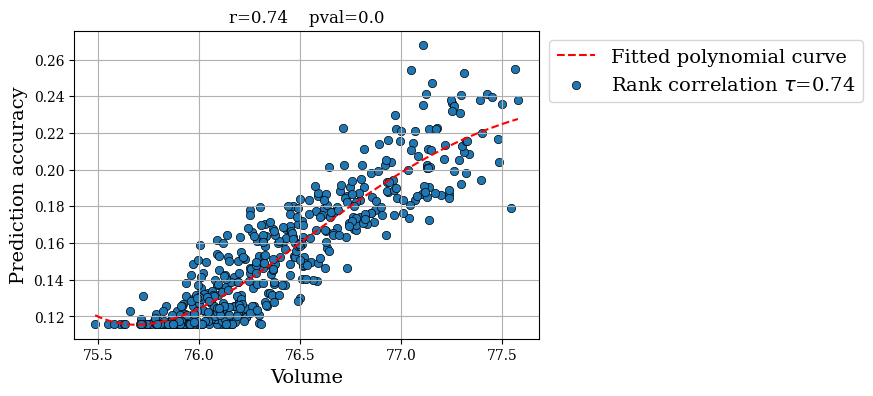

In [256]:
d = "bloodmnist"
d = "dermamnist"
# d = "retinamnist"
# d = "pathmnist"
# d = 'tissuemnist'
# d = 'organamnist'

class_bc = results[d]["class_bc"]
vs = results[d]["vs"]
bin_us = results[d]["bin_us"]
multi_us = results[d]["multi_us"]
cluster_us = results[d]["cluster_us"]
num_corr_class = results[d]["num_corr_class"]

# _x = [v["l2"] for v in vs]
# _x = [v["cosine"] for v in vs]
# _x = [v["relevance"] for v in vs]
# _x = [v["dispersion"] for v in vs]
_x = [v["volume"] for v in vs]
# _x = [v["vendi"] for v in vs]
# _x = num_corr_class
# _y = bin_us
_y = multi_us
# _y = cluster_us

coefficients = np.polyfit(_x, _y, 10)  # Fit the polynomial (degree 2)
polynomial = np.poly1d(
    coefficients
)  # Create a polynomial function with the fitted coefficients
x_fit = np.linspace(
    min(_x), max(_x), 100
)  # Generate x values for plotting the polynomial fit
y_fit = polynomial(x_fit)
# r = pearsonr(_x, _y)
r = kendalltau(_x, _y)
plt.figure(figsize=(6, 4))
plt.plot(x_fit, y_fit, color="red", label="Fitted polynomial curve", ls="--")
plt.scatter(
    _x,
    _y,
    label=rf"Rank correlation $\tau$={round(r.statistic, 2)}",
    edgecolors="k",
    lw=0.5,
)
plt.title(f"r={round(r.statistic, 2)}    pval={round(r.pvalue, 6)}")
# plt.title(fr"$\tau$={round(r.statistic, 2)}", fontsize=14)
plt.grid()
# plt.xlabel('Data measurement', fontsize=14)
# plt.xlabel('Relevance', fontsize=14)
plt.xlabel("Volume", fontsize=14)
# plt.xlabel('Number of data points with relevant labels', fontsize=14)
plt.ylabel("Prediction accuracy", fontsize=14)
# plt.ylim(0.0, 1)
plt.legend(fontsize=14, bbox_to_anchor=(1, 1))
# plt.savefig(fig_dir / f"{d}_correlation_multi.eps", bbox_inches='tight')
# plt.savefig(fig_dir / f"{d}_correlation_cluster.eps", bbox_inches='tight')

# 